In [47]:
import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer 

In [48]:
# Get the absolute path to the data directory
abs_dir = os.path.abspath(os.path.dirname(os.getcwd()))

In [49]:
df = pd.read_csv(os.path.join(abs_dir,'scripts/data/boa_reviews_20250608_162800.csv'))

In [50]:
pd.set_option('display.max_colwidth', None)

df.head(5)

,review_text,rating,upvote,date,bank_name,source
0,it's not working,3,0,2025-06-05,Bank of Abyssinia,Google Play
1,"Hello, I’m facing a problem with the BOA Mobile app. Every time I enter my phone number and password, the app crashes and shows an error that says “BoaMobile closed because this app has a bug.” I tried updating, reinstalling, and clearing cache, but nothing worked. Please fix this bug in the next update. I really need access to my account. Thank you.",1,0,2025-06-03,Bank of Abyssinia,Google Play
2,exceptional,5,0,2025-06-03,Bank of Abyssinia,Google Play
3,BoA Mobile good bank,5,0,2025-06-02,Bank of Abyssinia,Google Play
4,this is worest app 24/7 loading,1,0,2025-06-01,Bank of Abyssinia,Google Play


In [51]:
# check types 
df.dtypes

review_text    object
rating          int64
upvote          int64
date           object
bank_name      object
source         object
dtype: object

In [52]:
df.describe()

,rating,upvote
count,1044.000000,1044.000000
mean,3.063218,10.039272
std,1.860893,77.112271
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,1.000000
75%,5.000000,2.000000
max,5.000000,1810.000000


In [53]:
# check for null values in the DataFrame
df.isnull().sum()

review_text    0
rating         0
upvote         0
date           0
bank_name      0
source         0
dtype: int64

### Remove Duplicate Entries

When I check for duplicate entries in general, I find 81 duplicate rows. However, when I define duplicates based on both review_text and rating, the number increases to 1,162 rows. This indicates that the most influential factors in identifying duplicates are the review text and the rating.

In [54]:
# Check for duplicated data
dublicated_data = df.duplicated(subset=['review_text', 'rating'], keep=False).sum()
print(f'data duplicated: {dublicated_data}')
df[df.duplicated()]

data duplicated: 170


,review_text,rating,upvote,date,bank_name,source
31,good,4,0,2025-04-30,Bank of Abyssinia,Google Play
644,best,5,1,2024-05-02,Bank of Abyssinia,Google Play
764,Good,5,1,2024-04-22,Bank of Abyssinia,Google Play
933,Best app,5,1,2024-02-16,Bank of Abyssinia,Google Play


In [55]:
# remove duplicated data
df.drop_duplicates(subset=['review_text', 'rating'], keep='first', inplace=True)

In [56]:
# change date format from object to 'YYYY-MM-DD' format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.dtypes

review_text            object
rating                  int64
upvote                  int64
date           datetime64[ns]
bank_name              object
source                 object
dtype: object

In [57]:
df.shape

(911, 6)

In [58]:
!pip install transformers #distilBERT-base-uncased, which helps to classify the reviews
!pip install huggingface_hub[hf_xet] # for downloading the model from Hugging Face, for the purpose of sentiment analysis


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\elsha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#distilBERT-base-uncased,': Expected package name at the start of dependency specifier
    #distilBERT-base-uncased,
    ^


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\elsha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [59]:
from transformers import pipeline

# Load the sentiment analysis pipeline,  creates a pipeline for a specific NLP task. In this case, the task is sentiment analysis.
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english") 
#pipline is used to perform sentiment analysis on the review_text column

# Apply sentiment to review_text column
df['sentiment_result'] = df['review_text'].astype(str).apply(lambda x: sentiment_pipeline(x)[0]) 
#the above line applies the sentiment analysis pipeline to each review text and stores the result in a new column 'sentiment_result'
#astype(str) ensures that the review_text is treated as a string, even if it contains null values or other types.
#sentiment_pipeline(x)[0] returns the first result of the sentiment analysis, which is a dictionary containing the sentiment label and score.

df['sentiment_label'] = df['sentiment_result'].apply(lambda x: x['label'])
#the above line extracts the sentiment label (e.g., 'POSITIVE' or 'NEGATIVE') from the sentiment result and stores it in a new column 'sentiment_label'
#apply(lambda x: x['label']) is used to extract the label from each sentiment result.

df['sentiment_score'] = df['sentiment_result'].apply(lambda x: x['score'])
#the above line extracts the sentiment score (a numerical value indicating the confidence of the sentiment) from the sentiment result and stores it in a new column 'sentiment_score'

print(df[['review_text', 'sentiment_label', 'sentiment_score',"sentiment_result"]].head(5))


Device set to use cpu


                                                                                                                                                                                                                                                                                                                                                        review_text  \
0                                                                                                                                                                                                                                                                                                                                                  it's not working   
1  Hello, I’m facing a problem with the BOA Mobile app. Every time I enter my phone number and password, the app crashes and shows an error that says “BoaMobile closed because this app has a bug.” I tried updating, reinstalling, and clearing cache, but nothing worked. Please fix th

In [60]:
agg_mean = df.groupby(["bank_name", "rating"])["sentiment_score"].mean().reset_index()
#this line groups the DataFrame by 'bank_name' and 'rating', calculates the mean sentiment score for each group, and resets the index to create a new DataFrame with the results.
#reset_index() is used to convert the grouped DataFrame back into a regular DataFrame format.

print(agg_mean.head(5))

           bank_name  rating  sentiment_score
0  Bank of Abyssinia       1         0.976109
1  Bank of Abyssinia       2         0.958703
2  Bank of Abyssinia       3         0.964886
3  Bank of Abyssinia       4         0.973125
4  Bank of Abyssinia       5         0.955392


In [61]:
# Rename the column for clarity (optional)
agg_mean.rename(columns={'sentiment_score': 'avg_sentiment_score'}, inplace=True)
#this line renames the 'sentiment_score' column to 'avg_sentiment_score' for clarity, indicating that it represents the average sentiment score for each group.

# agg_df = agg_mean.rename(columns={'sentiment_score': 'average_sentiment_score'}, inplace=True)
print(agg_mean.head(5))

           bank_name  rating  avg_sentiment_score
0  Bank of Abyssinia       1             0.976109
1  Bank of Abyssinia       2             0.958703
2  Bank of Abyssinia       3             0.964886
3  Bank of Abyssinia       4             0.973125
4  Bank of Abyssinia       5             0.955392


## Thematic Analysis
A theme refers to a recurring concept or topic within user reviews. For this challenge, themes will help summarize user feedback into actionable categories for the banks.

### Keyword Extraction & Manual/Rule-Based Clustering

In [62]:
verctorizer = TfidfVectorizer(max_features=100)

# Fit and transform the review_text column to create a TF-IDF matrix

tfidf_verctorized = verctorizer.fit_transform(df['review_text'].astype(str))

keywords = verctorizer.get_feature_names_out()

print(f"Number of keywords: {len(keywords)}")

print(f"Keywords: {keywords[:20]}")  # Display the first 10 keywords


Number of keywords: 100
Keywords: ['account' 'after' 'all' 'always' 'an' 'and' 'app' 'application' 'apps'
 'are' 'as' 'at' 'bad' 'bank' 'banking' 'be' 'because' 'best' 'better'
 'boa']


In [63]:


bank_keywords = {}
# grouped_by_bank = df.groupby('bank_name')
# print(" grouped by bank name  ",grouped_by_bank) # this line counts the number of reviews for each bank and displays the result.



for bank, group in df.groupby('bank_name'): # grouping the DataFrame by 'bank_name', output is a dictionary-like object where each key is a bank name and each value is a DataFrame containing the reviews for that bank.

    vectorizer = TfidfVectorizer(max_features=100, stop_words='english')

    print("bank", bank)  # Display the bank name and its corresponding group of reviews
    #print( "group", group["review_text"].head(5))  # Display the first 5 reviews for the current bank

    tfidf_matrix = vectorizer.fit_transform(group['review_text'].astype(str)) # this line fits the TF-IDF vectorizer to the review_text of each bank and transforms it into a TF-IDF matrix.

    keywords = vectorizer.get_feature_names_out()
    # print("keywords for bank:", bank, "->", keywords)  # Display the keywords for each bank
    
    bank_keywords[bank] = keywords # Store the keywords for each bank in the dictionary,eg. CBE:{keyword1, keyword2, ...}

    print("bank_keywords:", bank_keywords)  # Display the dictionary containing keywords for each bank




bank Bank of Abyssinia
bank_keywords: {'Bank of Abyssinia': array(['able', 'abyssinia', 'access', 'account', 'activate', 'android',
       'annoying', 'apollo', 'app', 'application', 'apps', 'bad', 'bank',
       'banking', 'banks', 'best', 'better', 'birr', 'boa', 'bug', 'cbe',
       'connection', 'crashes', 'crashing', 'customers', 'days',
       'developer', 'didn', 'does', 'doesn', 'don', 'easy', 'error',
       'ethiopia', 'experience', 'fast', 'features', 'fix', 'frequently',
       'functional', 'good', 'great', 'improve', 'issue', 'just', 'keeps',
       'know', 'like', 'load', 'login', 'long', 'make', 'mobile', 'money',
       'need', 'needs', 'new', 'nice', 'ok', 'open', 'option', 'options',
       'otp', 'phone', 'poor', 'previous', 'problem', 'properly',
       'really', 'says', 'seen', 'service', 'slow', 'takes', 'thank',
       'time', 'times', 'transaction', 'transactions', 'transfer', 'try',
       'turn', 'update', 'updated', 'use', 'used', 'useless', 'user',
       '

In [64]:
global theme_keywords # Initialize an empty dictionary to store themes and their associated keywords
theme_keywords = {
    'Account Access Issues': ['login', 'access', 'account', 'password', 'blocked', 'error'],
    'Transaction Performance': ['transaction', 'delay', 'payment', 'processing', 'funds', 'failed'],
    'User Interface & Experience': ['app', 'interface', 'design', 'navigation', 'crash', 'slow'],
    'Customer Support': ['support', 'agent', 'response', 'feedback', 'service'],
    'Feature Requests': ['feature', 'add', 'need', 'want', 'update', 'new']
} #t this returns a dictionary where each key is a theme and each value is a list of keywords associated with that theme.

## Manual Grouping 

In [65]:


bank_theme_mapping = {}

for bank, keywords in bank_keywords.items():
    theme_counts = {theme: 0 for theme in theme_keywords}
    
    for word in keywords:
        for theme, word_list in theme_keywords.items():
            if word in word_list:
                theme_counts[theme] += 1
    
    # Sort and keep top 3–5 themes
    sorted_themes = sorted(theme_counts.items(), key=lambda x: x[1], reverse=True) #x[1] is used to sort the themes based on their counts in descending order.
    bank_theme_mapping[bank] = [theme for theme, count in sorted_themes if count > 0][:5]

# Display
for bank, top_themes in bank_theme_mapping.items():
    print(f"{bank}: {top_themes}")

Bank of Abyssinia: ['Account Access Issues', 'Feature Requests', 'User Interface & Experience', 'Transaction Performance', 'Customer Support']



## 🚀 Alternative Approach: Use Embedding Similarity (with spaCy)
This approach:

Uses word embeddings to measure similarity between keywords and theme labels.

Dynamically assigns keywords to themes without hardcoding word lists.

Works well when keywords are varied or noisy.

pip install spacy
python -m spacy download en_core_web_md 

## 🧠 What is spaCy?

spaCy is a popular open-source Natural Language Processing (NLP) library in Python.

✅ It provides:
Tokenization (splitting sentences into words)

Part-of-speech tagging (e.g., noun, verb)

Named entity recognition (e.g., people, places)

Word vectors / embeddings (words as mathematical vectors for similarity)

Dependency parsing (grammar structure of a sentence)

🔍 Why is spaCy useful?
You can compare words by meaning using pre-trained word vectors.

It allows semantic similarity, like matching "login" with "access issue".

But spaCy is not required for everything — you can do topic grouping without it.

In [66]:
!pip install spacy #this library is used for natural language processing tasks, such as tokenization, part-of-speech tagging, and named entity recognition.

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\elsha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#this': Expected package name at the start of dependency specifier
    #this
    ^


In [67]:
import spacy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Load spaCy model with word vectors
nlp = spacy.load("en_core_web_md")

# Define theme labels (you can adjust these)
themes = ['Account Access Issues', 'Transaction Performance', 'User Interface & Experience', 'Customer Support', 'Feature Requests']

# Embed themes
theme_vectors = {theme: nlp(theme).vector for theme in themes}

bank_theme_mapping = {}

for bank, group in df.groupby('bank_name'):
    # TF-IDF vectorization for current bank
    vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(group['review_text'].astype(str))
    keywords = vectorizer.get_feature_names_out()
    
    # Assign each keyword to the most similar theme
    theme_count = {theme: 0 for theme in themes}
    
    for kw in keywords:
        kw_vec = nlp(kw).vector
        if np.linalg.norm(kw_vec) == 0:
            continue  # skip empty vectors (rare but possible)
        
        # Compute cosine similarity
        similarities = {theme: np.dot(kw_vec, vec) / (np.linalg.norm(vec) * np.linalg.norm(kw_vec)) for theme, vec in theme_vectors.items()}
        best_theme = max(similarities, key=similarities.get)
        theme_count[best_theme] += 1
    
    # Get top 3–5 themes
    sorted_themes = sorted(theme_count.items(), key=lambda x: x[1], reverse=True)
    bank_theme_mapping[bank] = [theme for theme, count in sorted_themes if count > 0][:5]

# Output themes per bank
for bank, top_themes in bank_theme_mapping.items():
    print(f"{bank}: {top_themes}")


OSError: [E050] Can't find model 'en_core_web_md'. It doesn't seem to be a Python package or a valid path to a data directory.

## Pipeline

Script preprocessing (tokenization, stop-word removal, lemmatization if useful) with Pandas and NLP libraries.

In [68]:
#import dependencies
import pandas as pd
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize #for text preprocessing, which includes tokenization, stopword removal, and lemmatization
from nltk.stem import WordNetLemmatizer #for text preprocessing, which includes tokenization, stopword removal, and lemmatization
 
#sentiment analysis
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer #for sentiment analysis
from sklearn.feature_extraction.text import TfidfVectorizer #for text vectorization, means converting text data into numerical format that machine learning algorithms can understand, what TF-IDF does is that it takes into account both the frequency of words and their importance in the context of the document, which can help the model understand the meaning and relevance of words in the text.
from sklearn.model_selection import train_test_split #for splitting the dataset into training and testing sets
from sklearn.naive_bayes import MultinomialNB #for building a Naive Bayes classifier, which is a simple and effective algorithm for text classification tasks
from sklearn.metrics import accuracy_score

#keyword Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#visuals
import matplotlib.pyplot as plt
from wordcloud import WordCloud #for visualizing text data

In [69]:
# Download NLTK resources
nltk.download('punkt') # for tokenization, means splitting text into words
nltk.download('stopwords') # for removing common words like 'the', 'is', etc.
nltk.download('averaged_perceptron_tagger') # for part-of-speech tagging, meaning identifying the grammatical category of words
nltk.download('vader_lexicon') # for sentiment analysis using VADER
nltk.download('wordnet') # for lemmatization, which is reducing words to their base form, eg. 'running' to 'run'
nltk.download('omw-1.4') # for lemmatization with WordNet, which is a lexical database for the English language
nltk.download('punkt') # for tokenization, which is splitting text into sentences or words
nltk.download('punkt_tab') # for tokenization with tab-separated values, which is useful for processing text data in a tabular format

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elsha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elsha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\elsha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\elsha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elsha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\elsha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-d

True

In [70]:
# Preprocess text function
def preprocess_text(text):
    tokens = word_tokenize(text.lower()) # Tokenize and convert to lowercase
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer, which reduces words to their base form
    stop_words = set(stopwords.words('english')) # Set of common words to remove, like 'the', 'is', etc.
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words] # Remove non-alphanumeric tokens and stopwords
    return ' '.join(tokens) # Join tokens back into a single string

# Apply preprocessing       
df['processed_review'] = df['review_text'].apply(preprocess_text) # Display the first few rows of the processed reviews

print(df['processed_review'].head(5)) # Display the first few rows of the processed reviews


0                                                                                                                                                                                                                                           working
1    hello facing problem boa mobile app every time enter phone number password app crash show error say boamobile closed app tried updating reinstalling clearing cache nothing worked please fix bug next update really need access account thank
2                                                                                                                                                                                                                                       exceptional
3                                                                                                                                                                                                                              boa mobile good bank
4                       

In [71]:
# Create a new column named identified_theme
df['identified_theme'] = df['bank_name'].map(bank_theme_mapping).apply(lambda x: ', '.join(x))
# Define the columns you want to save
columns_to_save = ['review_text', 'sentiment_label', 'sentiment_score', 'identified_theme']

# Save the results to a CSV file
# df[columns_to_save].to_csv('results.csv', index=False)
for bank_name, group in df.groupby('bank_name'):
    columns_to_save = ['review_text', 'sentiment_label', 'sentiment_score', 'identified_theme']
    group[columns_to_save].to_csv(f'results_of_{bank_name}.csv', index=False)

df['identified_theme'].head(5)  # Display the first few rows of the identified themes

0    Account Access Issues, Feature Requests, User Interface & Experience, Transaction Performance, Customer Support
1    Account Access Issues, Feature Requests, User Interface & Experience, Transaction Performance, Customer Support
2    Account Access Issues, Feature Requests, User Interface & Experience, Transaction Performance, Customer Support
3    Account Access Issues, Feature Requests, User Interface & Experience, Transaction Performance, Customer Support
4    Account Access Issues, Feature Requests, User Interface & Experience, Transaction Performance, Customer Support
Name: identified_theme, dtype: object

In [72]:
# Preprocessing function

# This function takes a text input, tokenizes it, removes stopwords, and lemmatizes the words.
def preprocess_text(text):
    tokens = word_tokenize(text.lower()) # Tokenize and convert to lowercase
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer, which reduces words to their base form
    stop_words = set(stopwords.words('english')) # Set of common words to remove, like 'the', 'is', etc.
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words] # Remove non-alphanumeric tokens and stopwords
    return ' '.join(tokens) # Join tokens back into a single string

# Apply preprocessing       
df['processed_review'] = df['review_text'].apply(preprocess_text) # Display the first few rows of the processed reviews

print(df['processed_review'].head(5)) # Display the first few rows of the processed reviews


0                                                                                                                                                                                                                                           working
1    hello facing problem boa mobile app every time enter phone number password app crash show error say boamobile closed app tried updating reinstalling clearing cache nothing worked please fix bug next update really need access account thank
2                                                                                                                                                                                                                                       exceptional
3                                                                                                                                                                                                                              boa mobile good bank
4                       

In [73]:
# Vectorize the dataset

df_results = pd.read_csv(f'results_of_{bank_name}.csv')  # Read the results CSV file

vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df_results['review_text'].astype(str))  # Convert review_text to string and fit the vectorizer

# Get top keywords
keywords = vectorizer.get_feature_names_out()
print("Top Keywords:", keywords)




Top Keywords: ['account' 'after' 'all' 'always' 'an' 'and' 'app' 'application' 'apps'
 'are' 'as' 'at' 'bad' 'bank' 'banking' 'be' 'because' 'best' 'better'
 'boa' 'but' 'can' 'crashes' 'developer' 'do' 'doesn' 'don' 'easy' 'even'
 'ever' 'fast' 'fix' 'for' 'from' 'good' 'great' 'has' 'have' 'if' 'in'
 'is' 'it' 'its' 'just' 'keeps' 'like' 'login' 'make' 'me' 'mobile'
 'money' 'more' 'much' 'my' 'need' 'new' 'nice' 'not' 'of' 'off' 'on'
 'one' 'open' 'option' 'options' 'or' 'other' 'otp' 'phone' 'please'
 'service' 'slow' 'so' 'system' 'than' 'that' 'the' 'they' 'this' 'time'
 'to' 'try' 'update' 'use' 'using' 'version' 'very' 'was' 'we' 'what'
 'when' 'why' 'will' 'with' 'work' 'working' 'worst' 'you' 'your' 'ነው']


## Cluster into 3–5 themes per bank (e.g., UI, reliability).

In [74]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [76]:
from collections import defaultdict
bank_themes = {}

# Define themes and their associated keywords
for bank, keywords in bank_keywords.items():
    theme_count = defaultdict(int)
    for word in keywords:
        for theme, words in theme_counts.items():
            # if word.lower() in words:
                theme_count[theme] += 1
            #  if not isinstance(words, list):
            #     print(f"⚠️ Problem: Theme '{theme}' has a non-list value: {words}")
            
    bank_themes[bank] = dict(theme_count)

# Optionally, view results
import pandas as pd
theme_df = pd.DataFrame(bank_themes).fillna(0).astype(int)
print(theme_df)


                             Bank of Abyssinia
Account Access Issues                      100
Transaction Performance                    100
User Interface & Experience                100
Customer Support                           100
Feature Requests                           100


### Compare Banks

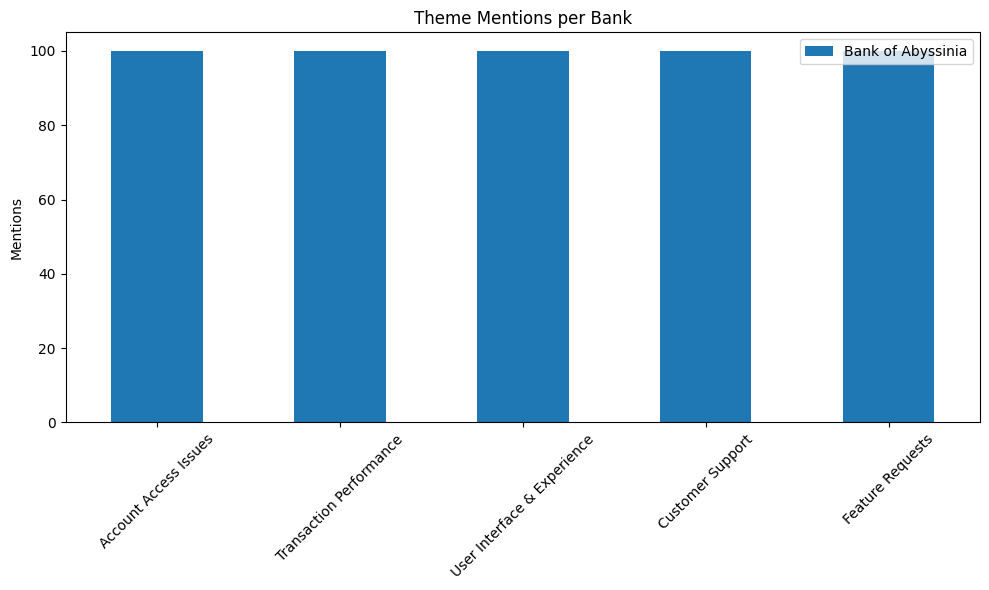

In [77]:
import matplotlib.pyplot as plt
import pandas as pd

theme_df = pd.DataFrame(bank_themes).fillna(0)
theme_df.plot(kind='bar', figsize=(10,6), title="Theme Mentions per Bank")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
